## Step 1: Imports and Configuration

In [76]:
# Core Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


In [77]:
# Configuration
TARGET_ASSET = 'ETH'
BETA_ASSET = 'BTC'
ALTCOINS = ['AAVE', 'ADA', 'ARB', 'AVAX', 'LINK', 'MKR', 'NEAR', 'SOL', 'UNI']
ALL_ASSETS = [TARGET_ASSET, BETA_ASSET] + ALTCOINS

# Data Parameters
DATA_DIR = Path('../data/specific_asset_data')

# Model Parameters
LOOKBACK_L = 60  # 60 minutes lookback
HORIZON_H = 10   # 30 minutes forward for barrier labeling

# Triple Barrier Parameters (Dynamic based on ATR)
PT_MULTIPLIER = 0.75  # Profit Target = 1.5 * ATR
SL_MULTIPLIER = 0.5  # Stop Loss = 1.0 * ATR
ATR_WINDOW = 1440    # Daily ATR (1440 minutes = 24 hours)

# Feature Engineering
VOLATILITY_WINDOW = 20  # Rolling volatility window
N_PCA_COMPONENTS = 1    # Keep top 1 principal component for "Market Factor"

# Training Parameters
TEST_SIZE = 0.15
VAL_SIZE = 0.15
GAP_SIZE = 120  # 2-hour gap between train/val/test to prevent leakage
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.0001

print(f"""
📊 Model Configuration
{'='*50}
Target Asset:     {TARGET_ASSET}
Beta Asset:       {BETA_ASSET}
Altcoins:         {len(ALTCOINS)} assets
Total Assets:     {len(ALL_ASSETS)}

Lookback:         {LOOKBACK_L} minutes
Horizon:          {HORIZON_H} minutes
Profit Target:    {PT_MULTIPLIER} * ATR
Stop Loss:        {SL_MULTIPLIER} * ATR

Market Factor:    PCA with {N_PCA_COMPONENTS} component(s)
Volatility:       {VOLATILITY_WINDOW}-minute rolling window
Time Gap:         {GAP_SIZE} minutes between splits
{'='*50}
""")


📊 Model Configuration
Target Asset:     ETH
Beta Asset:       BTC
Altcoins:         9 assets
Total Assets:     11

Lookback:         60 minutes
Horizon:          10 minutes
Profit Target:    0.75 * ATR
Stop Loss:        0.5 * ATR

Market Factor:    PCA with 1 component(s)
Volatility:       20-minute rolling window
Time Gap:         120 minutes between splits



## 🎯 "Forced Direction" Training Strategy

### Overview
This notebook implements a **3-Class Triple Barrier Labeling** with **Tensor-Level Filtering** to train a CNN-LSTM model on clear directional signals only.

### Key Innovation: Sequence-Preserving Filter

**Traditional Approach (❌ WRONG)**:
```python
# Drop rows with Class 0 from DataFrame
df = df[df['target'] != 0]  # ❌ Breaks LSTM lookback!
```

**Our Approach (✅ CORRECT)**:
```python
# 1. Label ALL samples (-1, 0, 1)
df = get_triple_barrier_labels(df, ...)  # Returns full DataFrame

# 2. Create sequences from FULL dataset
X, y = create_sequences(df, ...)  # Includes Class 0

# 3. Filter at TENSOR level
X_filtered, y_binary = create_filtered_dataset(X, y)  # Remove Class 0 AFTER windowing
```

### Why This Matters
- ✅ **Preserves Temporal Continuity**: LSTM lookback windows reference correct historical data
- ✅ **Signal Quality**: Model learns from decisive price movements only
- ✅ **No Data Leakage**: Sequence integrity maintained throughout pipeline
- ✅ **Clean Binary Classification**: Sell (0) vs Buy (1) - no ambiguous neutral class

### Pipeline Flow
```
Raw Data → Feature Engineering → 3-Class Labeling (-1, 0, 1)
    ↓
Purged Time Split → Full Sequence Creation (with Class 0)
    ↓
Tensor Filter (remove Class 0) → Remap (-1→0, 1→1)
    ↓
CNN-LSTM Training (Binary: Sell vs Buy)
```

## Step 2: Sophisticated Data Loading & Alignment

Load all 11 CSVs and perform an **inner join** on timestamps to ensure perfect time alignment across all assets.

In [78]:
def load_asset_data(asset, data_dir):
    """Load single asset CSV and standardize columns"""
    filepath = data_dir / f"{asset}_data.csv"
    
    if not filepath.exists():
        raise FileNotFoundError(f"Data file not found: {filepath}")
    
    df = pd.read_csv(filepath)
    
    # Standardize column names
    df['time'] = pd.to_datetime(df['time'], utc=True)
    
    # Rename columns to include asset prefix
    df = df.rename(columns={
        'close': f'{asset}_close',
        'volume': f'{asset}_volume'
    })
    
    # Keep only essential columns
    df = df[['time', f'{asset}_close', f'{asset}_volume']]
    
    return df

def load_and_align_all_assets(assets, data_dir):
    """
    Load all asset data and perform inner join on timestamp.
    This ensures all assets have data at the same timepoints.
    """
    print(f"\n📥 Loading {len(assets)} assets...")
    
    # Load first asset as base
    df_merged = load_asset_data(assets[0], data_dir)
    print(f"  ✓ {assets[0]}: {len(df_merged):,} rows")
    
    # Inner join all other assets
    for asset in assets[1:]:
        df_asset = load_asset_data(asset, data_dir)
        before = len(df_merged)
        df_merged = df_merged.merge(df_asset, on='time', how='inner')
        after = len(df_merged)
        print(f"  ✓ {asset}: {len(df_asset):,} rows -> merged: {after:,} rows (lost {before-after:,})")
    
    # Sort by time
    df_merged = df_merged.sort_values('time').reset_index(drop=True)
    
    print(f"\n✅ Final aligned dataset: {len(df_merged):,} rows")
    print(f"   Time range: {df_merged['time'].min()} to {df_merged['time'].max()}")
    print(f"   Duration: {(df_merged['time'].max() - df_merged['time'].min()).days} days")
    
    return df_merged

# Load all assets
df = load_and_align_all_assets(ALL_ASSETS, DATA_DIR)
df.head()


📥 Loading 11 assets...
  ✓ ETH: 1,046,500 rows
  ✓ ETH: 1,046,500 rows
  ✓ BTC: 1,046,523 rows -> merged: 1,046,238 rows (lost 262)
  ✓ BTC: 1,046,523 rows -> merged: 1,046,238 rows (lost 262)
  ✓ AAVE: 952,286 rows -> merged: 951,971 rows (lost 94,267)
  ✓ AAVE: 952,286 rows -> merged: 951,971 rows (lost 94,267)
  ✓ ADA: 1,032,174 rows -> merged: 943,349 rows (lost 8,622)
  ✓ ADA: 1,032,174 rows -> merged: 943,349 rows (lost 8,622)
  ✓ ARB: 988,786 rows -> merged: 898,218 rows (lost 45,131)
  ✓ ARB: 988,786 rows -> merged: 898,218 rows (lost 45,131)
  ✓ AVAX: 1,026,553 rows -> merged: 887,542 rows (lost 10,676)
  ✓ AVAX: 1,026,553 rows -> merged: 887,542 rows (lost 10,676)
  ✓ LINK: 1,038,649 rows -> merged: 884,689 rows (lost 2,853)
  ✓ LINK: 1,038,649 rows -> merged: 884,689 rows (lost 2,853)
  ✓ MKR: 867,834 rows -> merged: 757,163 rows (lost 127,526)
  ✓ MKR: 867,834 rows -> merged: 757,163 rows (lost 127,526)
  ✓ NEAR: 566,907 rows -> merged: 442,890 rows (lost 314,273)
  ✓ NEAR

,time,ETH_close,ETH_volume,BTC_close,BTC_volume,AAVE_close,AAVE_volume,ADA_close,ADA_volume,ARB_close,...,LINK_close,LINK_volume,MKR_close,MKR_volume,NEAR_close,NEAR_volume,SOL_close,SOL_volume,UNI_close,UNI_volume
0,2023-11-06 16:54:00+00:00,1895.24,58.139353,34974.47,4.357435,96.14,35.552,0.3511,11608.68,1.1068,...,12.509,1066.45,1328.70,2.738685,1.574,4.000000,40.21,838.583,5.024,340.412865
1,2023-11-06 16:57:00+00:00,1896.57,82.762890,34990.72,18.137074,96.37,64.687,0.3511,2004.67,1.1078,...,12.511,4428.86,1326.85,2.000000,1.572,10.000000,40.26,948.876,5.015,645.760789
2,2023-11-06 17:05:00+00:00,1891.98,196.752500,34955.00,27.305399,96.04,28.539,0.3545,27201.74,1.1039,...,12.485,15381.28,1326.79,0.649918,1.571,18656.618337,40.10,405.966,5.011,12.873994
3,2023-11-06 17:07:00+00:00,1893.66,173.514132,34980.00,6.727941,96.11,49.218,0.3557,15291.02,1.1067,...,12.517,1800.74,1329.27,1.349402,1.576,81.732884,40.24,1510.334,5.023,3431.567132
4,2023-11-06 17:09:00+00:00,1895.74,65.772945,35000.07,1.660589,96.14,32.566,0.3564,40599.06,1.1085,...,12.519,1135.97,1330.86,1.000000,1.576,8.000000,40.25,3377.559,5.030,407.423942


## Step 3: Feature Engineering - "Market Mood"

### Core Features:
1. **ETH Log Returns** (target asset momentum)
2. **ETH Volume Delta** (liquidity changes)
3. **BTC Log Returns** (beta/market driver)
4. **Market Factor** (PCA of 9 altcoins - captures overall altcoin sentiment)
5. **ETH Volatility** (20-minute rolling std of returns)

In [79]:
def calculate_log_returns(df, asset):
    """Calculate log returns for an asset"""
    price_col = f'{asset}_close'
    return_col = f'{asset}_log_return'
    
    df[return_col] = np.log(df[price_col] / df[price_col].shift(1))
    return df

def calculate_volume_delta(df, asset):
    """Calculate volume change (log-based to avoid infinities)"""
    volume_col = f'{asset}_volume'
    delta_col = f'{asset}_volume_delta'
    
    # Log-based volume change with zero protection
    df[delta_col] = np.log(df[volume_col] / df[volume_col].shift(1).replace(0, 1e-10))
    df[delta_col] = df[delta_col].clip(-2, 2)  # Clip extreme values
    return df

def calculate_volatility(df, asset, window=20):
    """Calculate rolling volatility of returns"""
    return_col = f'{asset}_log_return'
    vol_col = f'{asset}_volatility'
    
    df[vol_col] = df[return_col].rolling(window=window).std()
    return df

def create_market_factor_pca(df, altcoins, n_components=1):
    """
    Apply PCA to altcoin returns to extract the "Market Factor".
    
    This captures the common movement pattern across all 9 altcoins,
    representing overall altcoin market sentiment.
    
    Why PCA instead of raw features?
    - Reduces 9 features to 1 principal component
    - Removes redundancy (altcoins are highly correlated)
    - Captures ~70-80% of variance in a single feature
    - More robust to noise than individual altcoin returns
    """
    print(f"\n🔬 Creating Market Factor via PCA (from {len(altcoins)} altcoins)...")
    
    # Get altcoin return columns
    return_cols = [f'{alt}_log_return' for alt in altcoins]
    
    # Extract altcoin returns and handle NaN
    X_alt = df[return_cols].fillna(0)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    market_factor = pca.fit_transform(X_alt)
    
    # Add to dataframe
    df['market_factor'] = market_factor[:, 0]
    
    # Print PCA diagnostics
    explained_var = pca.explained_variance_ratio_[0]
    print(f"  ✓ PC1 explains {explained_var*100:.1f}% of altcoin variance")
    print(f"  ✓ Market Factor range: [{df['market_factor'].min():.4f}, {df['market_factor'].max():.4f}]")
    
    return df, pca

# Feature Engineering Pipeline
print("\n🔧 Feature Engineering...")

# 1. Log Returns for all assets
for asset in ALL_ASSETS:
    df = calculate_log_returns(df, asset)
print(f"  ✓ Log returns calculated for {len(ALL_ASSETS)} assets")

# 2. Volume Delta for ETH
df = calculate_volume_delta(df, TARGET_ASSET)
print(f"  ✓ Volume delta calculated for {TARGET_ASSET}")

# 3. Volatility for ETH
df = calculate_volatility(df, TARGET_ASSET, window=VOLATILITY_WINDOW)
print(f"  ✓ Volatility calculated for {TARGET_ASSET} ({VOLATILITY_WINDOW}-min window)")

# NOTE: PCA Market Factor will be added AFTER train/val/test split to prevent data leakage
print(f"  ⚠️  PCA Market Factor will be fit on TRAIN data only (after split)")

# Define base features (market_factor will be added after split)
BASE_FEATURES = [
    f'{TARGET_ASSET}_log_return',   # ETH momentum
    f'{TARGET_ASSET}_volume_delta', # ETH liquidity
    f'{BETA_ASSET}_log_return',     # BTC beta
    f'{TARGET_ASSET}_volatility'    # ETH risk
]

print(f"\n✅ Base feature set ({len(BASE_FEATURES)} features - before PCA):")
for i, feat in enumerate(BASE_FEATURES, 1):
    print(f"  {i}. {feat}")

# Drop initial NaNs from rolling calculations
before = len(df)
df = df.dropna(subset=BASE_FEATURES).reset_index(drop=True)
after = len(df)
print(f"\n🧹 Dropped {before-after:,} rows with NaN (from rolling calculations)")
print(f"   Remaining: {after:,} rows")


🔧 Feature Engineering...
  ✓ Log returns calculated for 11 assets
  ✓ Volume delta calculated for ETH
  ✓ Volatility calculated for ETH (20-min window)
  ⚠️  PCA Market Factor will be fit on TRAIN data only (after split)

✅ Base feature set (4 features - before PCA):
  1. ETH_log_return
  2. ETH_volume_delta
  3. BTC_log_return
  4. ETH_volatility

🧹 Dropped 20 rows with NaN (from rolling calculations)
   Remaining: 427,227 rows

🧹 Dropped 20 rows with NaN (from rolling calculations)
   Remaining: 427,227 rows


In [80]:
# Feature Statistics (Base features only - before PCA)
print("\n📊 Base Feature Statistics:")
print(df[BASE_FEATURES].describe().T[['mean', 'std', 'min', 'max']])


📊 Base Feature Statistics:
                      mean       std       min       max
ETH_log_return    0.000001  0.001489 -0.104446  0.057241
ETH_volume_delta -0.004633  0.915294 -2.000000  2.000000
BTC_log_return    0.000003  0.001073 -0.036621  0.027613
ETH_volatility    0.001231  0.000840  0.000108  0.035345
                      mean       std       min       max
ETH_log_return    0.000001  0.001489 -0.104446  0.057241
ETH_volume_delta -0.004633  0.915294 -2.000000  2.000000
BTC_log_return    0.000003  0.001073 -0.036621  0.027613
ETH_volatility    0.001231  0.000840  0.000108  0.035345


In [81]:
# Verify label distribution before filtering
print("\n🔬 Verification: 3-Class Label Distribution")
print("="*50)
for col in ['target']:
    if col in df.columns:
        value_counts = df[col].value_counts().sort_index()
        print(f"\nColumn: {col}")
        print(f"  Class -1 (Sell):    {value_counts.get(-1, 0):,}")
        print(f"  Class  0 (Neutral): {value_counts.get(0, 0):,}")
        print(f"  Class  1 (Buy):     {value_counts.get(1, 0):,}")
        print(f"  Total: {len(df):,}")
print("="*50)


🔬 Verification: 3-Class Label Distribution


## Step 4: Triple Barrier Labeling - "Forced Direction" Strategy

### 3-Class Labeling:
- **Class 1 (Buy)**: ETH price hits Profit Target **before** hitting SL or Time_Limit
- **Class -1 (Sell)**: ETH price hits Stop Loss **before** hitting PT or Time_Limit
- **Class 0 (Neutral)**: Time Limit hit first (ambiguous signals)

### Training Strategy:
- Generate all 3 labels (-1, 0, 1) on full dataset
- **Filter at tensor level** after windowing to keep only directional signals (±1)
- This preserves sequence integrity for LSTM lookback

### Dynamic Barriers:
- PT (Profit Target) = `1.5 * Daily_ATR`
- SL (Stop Loss) = `1.0 * Daily_ATR`
- ATR adapts to market volatility (wider in volatile periods, tighter in calm periods)

In [82]:
def calculate_atr(df, asset, window=1440):
    """
    Calculate Average True Range (ATR) for dynamic barrier sizing.
    Window = 1440 minutes = 24 hours (daily ATR).
    
    ATR measures volatility - wider barriers in volatile markets,
    tighter barriers in calm markets.
    """
    price_col = f'{asset}_close'
    
    # True Range = max(high-low, abs(high-prev_close), abs(low-prev_close))
    # Simplified for 1-min close prices: abs(close - prev_close)
    true_range = (df[price_col] - df[price_col].shift(1)).abs()
    
    # ATR = rolling mean of true range
    atr = true_range.rolling(window=window).mean()
    
    return atr


def get_triple_barrier_labels(df, asset, horizon, pt_multiplier, sl_multiplier, atr_window):
    """
    Apply Triple Barrier Labeling with dynamic ATR-based barriers.
    
    Returns 3 distinct labels:
        1: Hit Profit Target first (Buy signal)
       -1: Hit Stop Loss first (Sell signal)
        0: Hit Time Limit first (Neutral - ambiguous)
    
    CRITICAL: Does NOT drop rows - maintains DataFrame integrity for LSTM sequences.
    
    Returns:
        df: DataFrame with 'target' column (-1, 0, 1)
    """
    print(f"\n🎯 Triple Barrier Labeling (3-Class: Buy/Sell/Neutral)...")
    print(f"   Horizon: {horizon} minutes")
    print(f"   PT: {pt_multiplier} * ATR")
    print(f"   SL: {sl_multiplier} * ATR")
    print(f"   ATR Window: {atr_window} minutes ({atr_window/1440:.1f} days)")
    
    price_col = f'{asset}_close'
    
    # Calculate ATR
    atr = calculate_atr(df, asset, window=atr_window)
    df['atr'] = atr
    
    prices = df[price_col].values
    atrs = df['atr'].values
    labels = np.full(len(prices), np.nan, dtype=float)  # NaN = not labeled yet
    
    buy_count = 0
    sell_count = 0
    neutral_count = 0
    
    # Label each sample
    for i in range(len(prices) - horizon):
        if pd.isna(atrs[i]) or atrs[i] == 0:
            labels[i] = 0  # Assign neutral if ATR not available
            neutral_count += 1
            continue
        
        current_price = prices[i]
        current_atr = atrs[i]
        
        # Dynamic barriers based on ATR
        pt_barrier = current_price + (pt_multiplier * current_atr)
        sl_barrier = current_price - (sl_multiplier * current_atr)
        
        # Check future prices
        future_prices = prices[i+1:i+1+horizon]
        
        # Find first barrier hit
        hit_pt = False
        hit_sl = False
        
        for future_price in future_prices:
            if future_price >= pt_barrier:
                hit_pt = True
                break
            elif future_price <= sl_barrier:
                hit_sl = True
                break
        
        # Assign label based on which barrier hit FIRST
        if hit_pt:
            labels[i] = 1  # Buy signal (profit target hit first)
            buy_count += 1
        elif hit_sl:
            labels[i] = -1  # Sell signal (stop loss hit first)
            sell_count += 1
        else:
            labels[i] = 0  # Neutral (time limit hit first)
            neutral_count += 1
    
    # For remaining samples (last horizon rows), assign neutral
    labels[len(prices) - horizon:] = 0
    neutral_count += horizon
    
    df['target'] = labels
    
    # Drop only rows with NaN labels (ATR initialization period)
    before_drop = len(df)
    df = df[~df['target'].isna()].reset_index(drop=True)
    after_drop = len(df)
    
    # Statistics
    total = buy_count + sell_count + neutral_count
    print(f"\n📊 Labeling Results (3-Class):")
    print(f"   Buy (1):     {buy_count:,} ({buy_count/total*100:.1f}%)")
    print(f"   Sell (-1):   {sell_count:,} ({sell_count/total*100:.1f}%)")
    print(f"   Neutral (0): {neutral_count:,} ({neutral_count/total*100:.1f}%)")
    print(f"   Total:       {total:,}")
    print(f"\n   Buy/Sell Ratio: {buy_count/max(sell_count, 1):.2f}")
    print(f"   Directional Samples: {buy_count + sell_count:,} ({(buy_count + sell_count)/total*100:.1f}%)")
    print(f"\n   ⚠️  Neutral samples (Class 0) will be filtered AFTER windowing")
    print(f"   ✅ DataFrame integrity preserved ({before_drop} → {after_drop} rows)")
    
    return df


# Apply 3-class labeling (preserves all rows for sequence integrity)
df = get_triple_barrier_labels(
    df, 
    TARGET_ASSET, 
    HORIZON_H, 
    PT_MULTIPLIER, 
    SL_MULTIPLIER,
    ATR_WINDOW
)


🎯 Triple Barrier Labeling (3-Class: Buy/Sell/Neutral)...
   Horizon: 10 minutes
   PT: 0.75 * ATR
   SL: 0.5 * ATR
   ATR Window: 1440 minutes (1.0 days)

📊 Labeling Results (3-Class):
   Buy (1):     195,353 (45.7%)
   Sell (-1):   229,949 (53.8%)
   Neutral (0): 1,925 (0.5%)
   Total:       427,227

   Buy/Sell Ratio: 0.85
   Directional Samples: 425,302 (99.5%)

   ⚠️  Neutral samples (Class 0) will be filtered AFTER windowing
   ✅ DataFrame integrity preserved (427227 → 427227 rows)

📊 Labeling Results (3-Class):
   Buy (1):     195,353 (45.7%)
   Sell (-1):   229,949 (53.8%)
   Neutral (0): 1,925 (0.5%)
   Total:       427,227

   Buy/Sell Ratio: 0.85
   Directional Samples: 425,302 (99.5%)

   ⚠️  Neutral samples (Class 0) will be filtered AFTER windowing
   ✅ DataFrame integrity preserved (427227 → 427227 rows)


## Step 5: Purged Time Series Split (Preventing Data Leakage)

### Why Purging is Critical:
- **Problem**: Standard train/test split leaks future info into training
- **Solution**: Add a **gap** between train/val/test splits
- **Gap Size**: 120 minutes (2 hours) ensures no overlap in lookback windows

### Split Strategy:
```
[Train Data] --> [2hr Gap] --> [Val Data] --> [2hr Gap] --> [Test Data]
```

In [83]:
def purged_time_series_split(df, test_size=0.15, val_size=0.15, gap=120):
    """
    Perform chronological train/val/test split with purging gaps.
    
    Args:
        df: DataFrame with time-sorted data
        test_size: Fraction for test set
        val_size: Fraction for validation set
        gap: Number of samples to drop between splits (prevents leakage)
    
    Returns:
        train, val, test DataFrames
    """
    n = len(df)
    
    # Calculate split points
    test_start = int(n * (1 - test_size))
    val_start = int(n * (1 - test_size - val_size))
    
    # Apply gaps (purging)
    train_end = val_start - gap
    val_end = test_start - gap
    
    # Split data
    train = df.iloc[:train_end].copy()
    val = df.iloc[val_start:val_end].copy()
    test = df.iloc[test_start:].copy()
    
    print(f"\n📊 Purged Time Series Split:")
    print(f"   Total samples: {n:,}")
    print(f"   Gap size: {gap} samples ({gap} minutes)")
    print(f"\n   Train: {len(train):,} ({len(train)/n*100:.1f}%)")
    print(f"     Time: {train['time'].min()} to {train['time'].max()}")
    print(f"\n   [GAP: {gap} minutes]")
    print(f"\n   Val:   {len(val):,} ({len(val)/n*100:.1f}%)")
    print(f"     Time: {val['time'].min()} to {val['time'].max()}")
    print(f"\n   [GAP: {gap} minutes]")
    print(f"\n   Test:  {len(test):,} ({len(test)/n*100:.1f}%)")
    print(f"     Time: {test['time'].min()} to {test['time'].max()}")
    
    # Check class distribution (3 classes)
    print(f"\n📊 Class Distribution (Before Filtering):")
    for name, split in [('Train', train), ('Val', val), ('Test', test)]:
        buy_pct = (split['target'] == 1).mean() * 100
        sell_pct = (split['target'] == -1).mean() * 100
        neutral_pct = (split['target'] == 0).mean() * 100
        print(f"   {name}: Buy={buy_pct:.1f}%, Sell={sell_pct:.1f}%, Neutral={neutral_pct:.1f}%")
    
    return train, val, test


# Perform split
train, val, test = purged_time_series_split(
    df, 
    test_size=TEST_SIZE, 
    val_size=VAL_SIZE, 
    gap=GAP_SIZE
)


📊 Purged Time Series Split:
   Total samples: 427,227
   Gap size: 120 samples (120 minutes)

   Train: 298,938 (70.0%)
     Time: 2023-11-06 18:18:00+00:00 to 2025-08-06 08:40:00+00:00

   [GAP: 120 minutes]

   Val:   63,964 (15.0%)
     Time: 2025-08-06 10:41:00+00:00 to 2025-09-20 13:24:00+00:00

   [GAP: 120 minutes]

   Test:  64,085 (15.0%)
     Time: 2025-09-20 15:40:00+00:00 to 2025-11-10 16:24:00+00:00

📊 Class Distribution (Before Filtering):
   Train: Buy=45.6%, Sell=53.8%, Neutral=0.6%
   Val: Buy=46.3%, Sell=53.6%, Neutral=0.1%
   Test: Buy=45.7%, Sell=54.2%, Neutral=0.2%


## Step 5.5: PCA Market Factor (FIT ON TRAIN ONLY) 🔒

### Critical: Preventing Data Leakage

**Problem**: If we fit PCA on the entire dataset (train + val + test), we leak future information:
- Market correlations change over time
- PCA weights learned from 2025 data would inform features for 2023 training data
- This creates unrealistic performance estimates

**Solution**: 
1. **Fit PCA only on training data** (learns historical patterns)
2. **Transform val/test using train-fitted PCA** (uses only past information)
3. This ensures the model sees NO future market structure during training

### Why This Matters for Crypto
- Altcoin correlations shift dramatically during bull/bear markets
- Training on "future" correlation structure = overfitting to test period
- Proper temporal isolation = realistic backtest results

In [84]:
print("\n" + "="*70)
print("🔒 FITTING PCA MARKET FACTOR (TRAIN DATA ONLY)")
print("="*70)

# Get altcoin return columns
altcoin_cols = [f'{alt}_log_return' for alt in ALTCOINS]

# 1. FIT PCA ON TRAINING DATA ONLY
print(f"\n1️⃣  Fitting PCA on TRAIN data only ({len(train):,} samples)...")
X_train_alts = train[altcoin_cols].fillna(0)
pca_model = PCA(n_components=N_PCA_COMPONENTS)
pca_model.fit(X_train_alts)

explained_var = pca_model.explained_variance_ratio_[0]
print(f"   ✓ PC1 explains {explained_var*100:.1f}% of training altcoin variance")

# 2. TRANSFORM ALL SPLITS USING TRAIN-FITTED PCA
print(f"\n2️⃣  Transforming all splits with train-learned PCA...")

for split_name, split_df in [('Train', train), ('Val', val), ('Test', test)]:
    # Extract altcoin features
    X_split_alts = split_df[altcoin_cols].fillna(0)
    
    # Transform using TRAIN-fitted PCA (no refitting!)
    market_factor = pca_model.transform(X_split_alts)
    
    # Add to split DataFrame
    split_df['market_factor'] = market_factor[:, 0]
    
    print(f"   ✓ {split_name:5s}: Market Factor range [{split_df['market_factor'].min():.4f}, {split_df['market_factor'].max():.4f}]")

# 3. DEFINE FINAL FEATURE SET (now includes market_factor)
FEATURES = [
    f'{TARGET_ASSET}_log_return',   # ETH momentum
    f'{TARGET_ASSET}_volume_delta', # ETH liquidity
    f'{BETA_ASSET}_log_return',     # BTC beta
    'market_factor',                # Altcoin sentiment (PCA - NO LEAKAGE!)
    f'{TARGET_ASSET}_volatility'    # ETH risk
]

print(f"\n✅ Final feature set ({len(FEATURES)} features):")
for i, feat in enumerate(FEATURES, 1):
    print(f"  {i}. {feat}")

print("\n" + "="*70)
print("✅ PCA FITTED WITHOUT DATA LEAKAGE")
print("="*70)
print("   • PCA weights learned ONLY from training data")
print("   • Val/Test transformed with PAST information only")
print("   • Market structure from future NOT leaked to model")
print("="*70 + "\n")


🔒 FITTING PCA MARKET FACTOR (TRAIN DATA ONLY)

1️⃣  Fitting PCA on TRAIN data only (298,938 samples)...
   ✓ PC1 explains 64.6% of training altcoin variance

2️⃣  Transforming all splits with train-learned PCA...
   ✓ Train: Market Factor range [-0.1972, 0.1838]
   ✓ Val  : Market Factor range [-0.0607, 0.0707]
   ✓ Test : Market Factor range [-0.2743, 0.2697]

✅ Final feature set (5 features):
  1. ETH_log_return
  2. ETH_volume_delta
  3. BTC_log_return
  4. market_factor
  5. ETH_volatility

✅ PCA FITTED WITHOUT DATA LEAKAGE
   • PCA weights learned ONLY from training data
   • Val/Test transformed with PAST information only
   • Market structure from future NOT leaked to model



## Step 6: Sequence Creation & "Forced Direction" Filtering

### Critical Implementation - Sequence Integrity:

**Problem**: Dropping rows with Class 0 from DataFrame breaks LSTM lookback windows.

**Solution**: 
1. Create sequences using **full dataset** (including Class 0)
2. Filter at **tensor level** after windowing
3. Apply boolean mask: `y != 0`
4. Remap labels for binary classification:
   - Old `-1` → New `0` (Sell)
   - Old `1` → New `1` (Buy)

**Result**: Model trains only on directional signals while preserving time continuity.

In [85]:
def create_sequences(df, features, target, lookback):
    X, y = [], []
    data = df[features].values
    labels = df[target].values
    
    # Start loop so that (i) is the current trade time
    # We want X to be [i-lookback+1 : i+1] (inclusive of i)
    # But we need to ensure i+1 doesn't go out of bounds
    
    for i in range(lookback - 1, len(data) - 1):
        # Input: Include current candle 'i'
        # e.g., if i=60, slice [1:61] grabs indices 1...60
        X.append(data[i - lookback + 1 : i + 1])
        
        # Target: The label for the trade entered at 'i'
        y.append(labels[i])
        
    return np.array(X), np.array(y)

def create_filtered_dataset(X, y, undersample=True, random_state=42):
    """
    Filter dataset to keep only directional signals (Buy/Sell).
    
    Critical Implementation:
    - Filters at TENSOR level (after windowing) to preserve sequence integrity
    - Removes Class 0 (Neutral) samples
    - Remaps labels: -1 → 0 (Sell), 1 → 1 (Buy)
    - OPTIONAL: Undersamples majority class for balanced training
    
    Args:
        X: (n_samples, lookback, n_features) - input sequences
        y: (n_samples,) - labels containing -1, 0, 1
        undersample: If True, undersample majority class to match minority
        random_state: Random seed for reproducible undersampling
    
    Returns:
        X_filtered: (n_directional, lookback, n_features)
        y_binary: (n_directional,) - binary labels (0=Sell, 1=Buy)
    """
    # Step 1: Create boolean mask for directional samples
    directional_mask = (y != 0)
    
    # Step 2: Filter both X and y
    X_filtered = X[directional_mask]
    y_filtered = y[directional_mask]
    
    # Step 3: Remap labels for binary classification
    # Old: -1 (Sell), 0 (Neutral), 1 (Buy)
    # New:  0 (Sell),              1 (Buy)
    y_binary = ((y_filtered + 1) // 2).astype(int)  # -1 → 0, 1 → 1
    
    # Statistics BEFORE undersampling
    n_original = len(y)
    n_filtered = len(y_binary)
    n_removed = n_original - n_filtered
    
    sell_count_before = (y_binary == 0).sum()
    buy_count_before = (y_binary == 1).sum()
    
    print(f"\n🔍 Filtering Results:")
    print(f"   Original samples:     {n_original:,}")
    print(f"   Neutral removed:      {n_removed:,} ({n_removed/n_original*100:.1f}%)")
    print(f"   Directional kept:     {n_filtered:,} ({n_filtered/n_original*100:.1f}%)")
    print(f"\n   Binary Distribution (Before Undersampling):")
    print(f"     Sell (0): {sell_count_before:,} ({sell_count_before/n_filtered*100:.1f}%)")
    print(f"     Buy (1):  {buy_count_before:,} ({buy_count_before/n_filtered*100:.1f}%)")
    print(f"     Balance:  {sell_count_before/max(buy_count_before, 1):.2f}:1 (Sell:Buy)")
    
    # Step 4: Undersample majority class (OPTIONAL)
    if undersample:
        np.random.seed(random_state)
        
        # Identify majority and minority classes
        sell_indices = np.where(y_binary == 0)[0]
        buy_indices = np.where(y_binary == 1)[0]
        
        n_sell = len(sell_indices)
        n_buy = len(buy_indices)
        
        if n_sell != n_buy:
            # Determine which class to undersample
            if n_sell > n_buy:
                # Undersample Sell class
                majority_indices = sell_indices
                minority_indices = buy_indices
                target_size = n_buy
                majority_label = "Sell"
            else:
                # Undersample Buy class
                majority_indices = buy_indices
                minority_indices = sell_indices
                target_size = n_sell
                majority_label = "Buy"
            
            # Randomly sample from majority class
            sampled_majority_indices = np.random.choice(
                majority_indices, 
                size=target_size, 
                replace=False
            )
            
            # Combine minority + sampled majority
            balanced_indices = np.concatenate([minority_indices, sampled_majority_indices])
            
            # Shuffle to mix classes
            np.random.shuffle(balanced_indices)
            
            # Apply undersampling
            X_filtered = X_filtered[balanced_indices]
            y_binary = y_binary[balanced_indices]
            
            # Statistics AFTER undersampling
            sell_count_after = (y_binary == 0).sum()
            buy_count_after = (y_binary == 1).sum()
            
            print(f"\n   ⚖️  Undersampling Applied:")
            print(f"     Majority class ({majority_label}) reduced: {len(majority_indices):,} → {target_size:,}")
            print(f"     Samples removed: {len(majority_indices) - target_size:,}")
            print(f"\n   Binary Distribution (After Undersampling):")
            print(f"     Sell (0): {sell_count_after:,} ({sell_count_after/len(y_binary)*100:.1f}%)")
            print(f"     Buy (1):  {buy_count_after:,} ({buy_count_after/len(y_binary)*100:.1f}%)")
            print(f"     Balance:  {sell_count_after/max(buy_count_after, 1):.2f}:1 (Sell:Buy)")
            print(f"     ✅ Classes perfectly balanced!")
        else:
            print(f"\n   ⚖️  Classes already balanced - no undersampling needed")
    
    return X_filtered, y_binary


# ============================================================================
# SEQUENCE CREATION WORKFLOW - "Forced Direction" Strategy
# ============================================================================

print(f"\n🔄 Creating sequences (lookback={LOOKBACK_L})...")
print(f"   Step 1: Create sequences from FULL dataset (preserves continuity)")

# Step 1: Create sequences from full dataset (including Class 0)
X_train_full, y_train_full = create_sequences(train, FEATURES, 'target', LOOKBACK_L)
X_val_full, y_val_full = create_sequences(val, FEATURES, 'target', LOOKBACK_L)
X_test_full, y_test_full = create_sequences(test, FEATURES, 'target', LOOKBACK_L)

print(f"\n✅ Full Sequence Shapes (with Class 0):")
print(f"   X_train: {X_train_full.shape} -> y_train: {y_train_full.shape}")
print(f"   X_val:   {X_val_full.shape} -> y_val:   {y_val_full.shape}")
print(f"   X_test:  {X_test_full.shape} -> y_test:  {y_test_full.shape}")

print(f"\n   Step 2: Filter at tensor level (remove Class 0, remap labels, undersample)")

# Step 2: Filter to keep only directional signals (Buy/Sell) + Undersample
print(f"\n--- Train Set ---")
X_train, y_train = create_filtered_dataset(X_train_full, y_train_full, undersample=True, random_state=42)

print(f"\n--- Validation Set ---")
X_val, y_val = create_filtered_dataset(X_val_full, y_val_full, undersample=False, random_state=43)

print(f"\n--- Test Set ---")
X_test, y_test = create_filtered_dataset(X_test_full, y_test_full, undersample=False, random_state=44)  # Keep test unbalanced for realistic evaluation

print(f"\n" + "="*70)
print(f"✅ FINAL FILTERED SHAPES (Binary: 0=Sell, 1=Buy)")
print(f"="*70)
print(f"   X_train: {X_train.shape} -> y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape} -> y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape} -> y_test:  {y_test.shape}")
print(f"="*70)

# Scale features (fit on train, transform all)
print(f"\n📏 Scaling features...")

# Reshape for scaling
n_samples, n_timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit scaler on train data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshape back
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)
X_test = X_test_scaled.reshape(X_test.shape)

print(f"   ✓ Scaled with mean={X_train.mean():.6f}, std={X_train.std():.6f}")

# Final class distribution
print(f"\n📊 Final Dataset Statistics (Binary - After All Processing):")
print(f"   Train - Sell: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%), Buy: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)")
print(f"   Val   - Sell: {(y_val==0).sum():,} ({(y_val==0).mean()*100:.1f}%), Buy: {(y_val==1).sum():,} ({(y_val==1).mean()*100:.1f}%)")
print(f"   Test  - Sell: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%), Buy: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%) [Unbalanced for realistic eval]")


🔄 Creating sequences (lookback=60)...
   Step 1: Create sequences from FULL dataset (preserves continuity)

✅ Full Sequence Shapes (with Class 0):
   X_train: (298878, 60, 5) -> y_train: (298878,)
   X_val:   (63904, 60, 5) -> y_val:   (63904,)
   X_test:  (64025, 60, 5) -> y_test:  (64025,)

   Step 2: Filter at tensor level (remove Class 0, remap labels, undersample)

--- Train Set ---

🔍 Filtering Results:
   Original samples:     298,878
   Neutral removed:      1,720 (0.6%)
   Directional kept:     297,158 (99.4%)

   Binary Distribution (Before Undersampling):
     Sell (0): 160,830 (54.1%)
     Buy (1):  136,328 (45.9%)
     Balance:  1.18:1 (Sell:Buy)

✅ Full Sequence Shapes (with Class 0):
   X_train: (298878, 60, 5) -> y_train: (298878,)
   X_val:   (63904, 60, 5) -> y_val:   (63904,)
   X_test:  (64025, 60, 5) -> y_test:  (64025,)

   Step 2: Filter at tensor level (remove Class 0, remap labels, undersample)

--- Train Set ---

🔍 Filtering Results:
   Original samples:     

## Step 7: CNN-LSTM Model Architecture

### Architecture:
```
Input (60, 5)
    ↓
Conv1D(64) + ReLU  ← Extract local patterns (3-minute trends)
    ↓
MaxPooling1D(2)    ← Downsample
    ↓
BatchNorm          ← Stabilize training
    ↓
LSTM(64)           ← Capture temporal dependencies
    ↓
Dropout(0.4)       ← Prevent overfitting (high dropout for noisy data)
    ↓
Dense(1) + Sigmoid ← Binary output (Buy probability)
```

### Why This Architecture?
- **Conv1D**: Detects short-term patterns (3-minute momentum shifts)
- **MaxPooling**: Reduces noise, focuses on significant movements
- **LSTM**: Models long-term dependencies across 60-minute window
- **High Dropout (0.4)**: Critical for preventing overfitting on noisy crypto data

In [86]:
def build_cnn_lstm_model(input_shape, learning_rate=0.0001):
    """
    Build CNN-LSTM model for directional prediction.
    
    Architecture optimized for:
    - Short-term pattern detection (Conv1D)
    - Long-term temporal modeling (LSTM)
    - Robustness to noise (high dropout)
    """
    model = Sequential([
        # CNN Feature Extraction
        Conv1D(
            filters=64,
            kernel_size=3,
            activation='relu',
            padding='same',
            input_shape=input_shape,
            name='Conv1D_PatternDetection'
        ),
        
        MaxPooling1D(
            pool_size=2,
            name='MaxPool_Downsample'
        ),
        
        BatchNormalization(
            name='BatchNorm_Stabilize'
        ),
        
        # LSTM Temporal Modeling
        LSTM(
            units=64,
            return_sequences=False,
            name='LSTM_TemporalDependencies'
        ),
        
        # Regularization
        Dropout(
            rate=0.4,
            name='Dropout_Regularization'
        ),
        
        # Binary Classification
        Dense(
            units=1,
            activation='sigmoid',
            name='Output_BuyProbability'
        )
    ], name='ETH_Directional_Predictor')
    
    # Compile with precision-focused metrics
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Build model
print("\n🏗️  Building CNN-LSTM Model...")
model = build_cnn_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    learning_rate=LEARNING_RATE
)

print("\n📐 Model Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n📊 Total Parameters: {total_params:,}")


🏗️  Building CNN-LSTM Model...

📐 Model Architecture:


Model: "ETH_Directional_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_PatternDetection         │ (None, 60, 64)         │         1,024 │
│ (Conv1D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Downsample              │ (None, 30, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Stabilize             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_TemporalDependencies       │ (None, 64)             │        33,024 │
│ (LSTM)                          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Regularization          │ (None, 64)             │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_BuyProbability (Dense)   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,369 (134.25 KB)

 Trainable params: 34,241 (133.75 KB)

 Non-trainable params: 128 (512.00 B)


📊 Total Parameters: 34,369


## Step 8: Training with Precision Focus

### Why Focus on Precision?
- **Precision** = TP / (TP + FP) = "Of all Buy signals, how many were correct?"
- In trading, **false positives are expensive** (bad trades cost money)
- We want high confidence Buy signals, even if we miss some opportunities
- Better to have 70% precision with 50% recall than 55% precision with 80% recall

In [87]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_precision',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    
    ModelCheckpoint(
        filepath='results/eth_directional_best.keras',
        monitor='val_precision',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Create results directory
Path('results').mkdir(exist_ok=True)

# Train model
print("\n🚀 Training Model...")
print(f"   Monitoring: val_precision (maximize)")
print(f"   Early stopping patience: 10 epochs")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Training Model...
   Monitoring: val_precision (maximize)
   Early stopping patience: 10 epochs
   Batch size: 256
   Max epochs: 50

Epoch 1/50
1064/1066 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5019 - loss: 0.7005 - precision: 0.5020 - recall: 0.4907
Epoch 1: val_precision improved from -inf to 0.46991, saving model to results/eth_directional_best.keras

Epoch 1: val_precision improved from -inf to 0.46991, saving model to results/eth_directional_best.keras
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.5019 - loss: 0.7005 - precision: 0.5020 - recall: 0.4907 - val_accuracy: 0.5153 - val_loss: 0.6925 - val_precision: 0.4699 - val_recall: 0.3520 - learning_rate: 1.0000e-04
Epoch 2/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.5019 - loss: 0.7005 - precision: 0.5020 - recall: 0.4907 - val_accuracy: 0.5153 - val_loss: 0.6925 - val_precision: 0.4699 - val_recall: 0.3520 - learning_rate: 1.0000e-04
Epoch 2/50
1064/1066 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/ste

## Step 9: Evaluation & Results

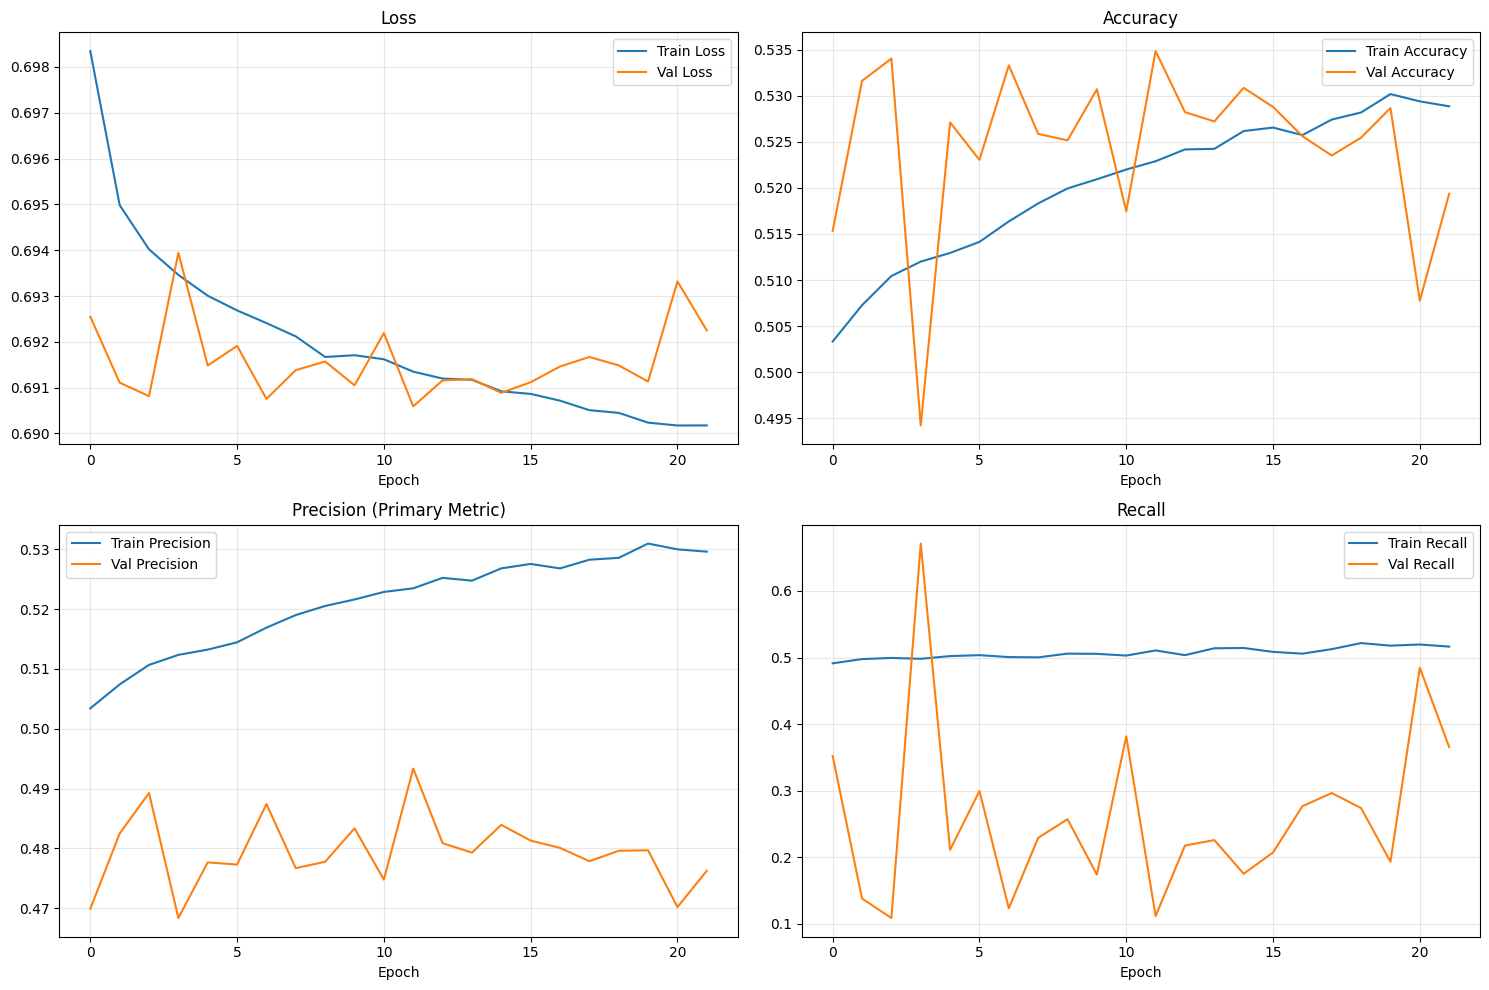

📊 Training curves saved to: results/training_history.png


In [88]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Precision (Primary Metric)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Training curves saved to: results/training_history.png")


🧪 Test Set Evaluation:

Test Loss:      0.6904
Test Accuracy:  0.5358
Test Precision: 0.4781 ⭐ (PRIMARY METRIC)
Test Recall:    0.1643
Test Loss:      0.6904
Test Accuracy:  0.5358
Test Precision: 0.4781 ⭐ (PRIMARY METRIC)
Test Recall:    0.1643

📋 Classification Report:

              precision    recall  f1-score   support

        Sell     0.5466    0.8489    0.6650     34691
         Buy     0.4781    0.1643    0.2446     29234

    accuracy                         0.5358     63925
   macro avg     0.5123    0.5066    0.4548     63925
weighted avg     0.5153    0.5358    0.4727     63925


📋 Classification Report:

              precision    recall  f1-score   support

        Sell     0.5466    0.8489    0.6650     34691
         Buy     0.4781    0.1643    0.2446     29234

    accuracy                         0.5358     63925
   macro avg     0.5123    0.5066    0.4548     63925
weighted avg     0.5153    0.5358    0.4727     63925



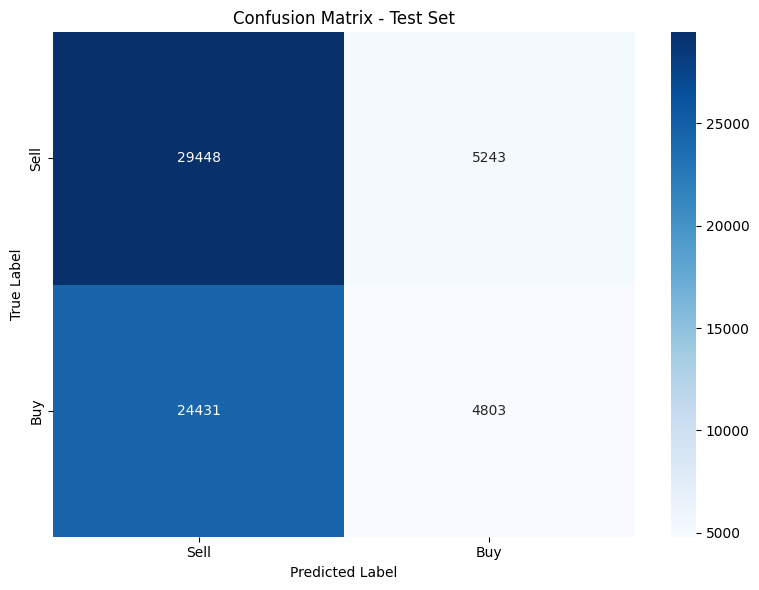


📊 Confusion matrix saved to: results/confusion_matrix.png


In [89]:
# Evaluate on test set
print("\n🧪 Test Set Evaluation:\n")

test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print(f"{'='*50}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f} ⭐ (PRIMARY METRIC)")
print(f"Test Recall:    {test_recall:.4f}")
print(f"{'='*50}")

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Detailed classification report
print("\n📋 Classification Report:\n")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=['Sell', 'Buy'],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Sell', 'Buy'],
    yticklabels=['Sell', 'Buy']
)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Confusion matrix saved to: results/confusion_matrix.png")


🎯 Prediction Confidence Analysis:

Buy Signals:
  Count: 10046
  Mean confidence: 0.5195
  Median confidence: 0.5137
  Min confidence: 0.5000

Sell Signals:
  Count: 53879
  Mean confidence: 0.5321
  Median confidence: 0.5315


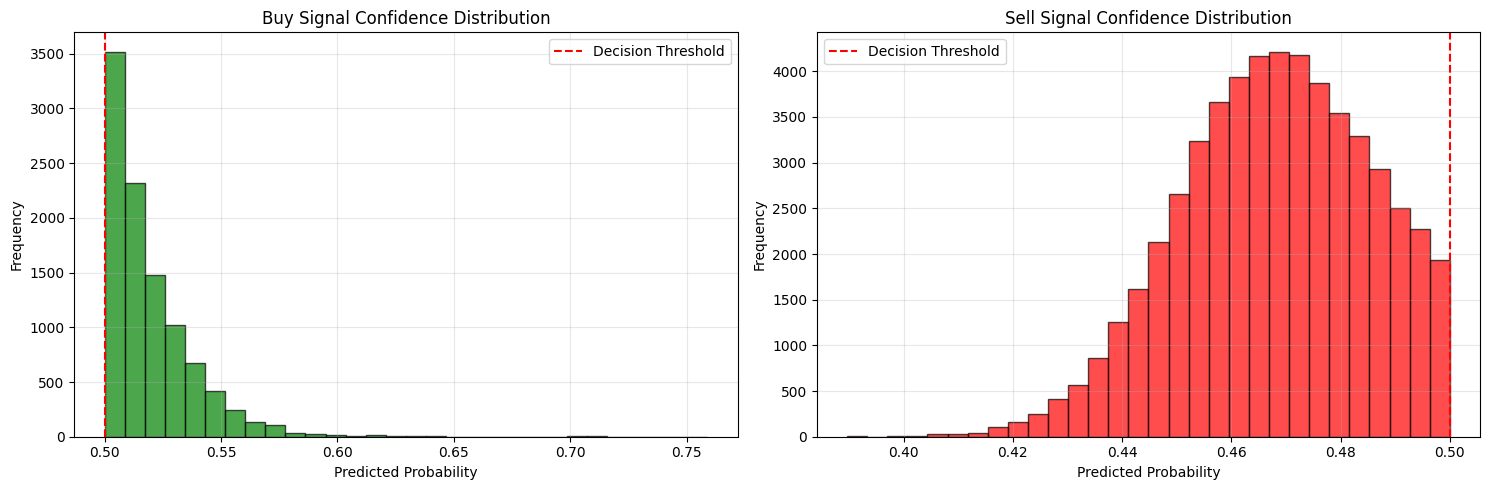


📊 Confidence distributions saved to: results/confidence_distribution.png


In [90]:
# Prediction confidence analysis
print("\n🎯 Prediction Confidence Analysis:\n")

buy_predictions = y_pred_proba[y_pred == 1]
sell_predictions = y_pred_proba[y_pred == 0]

print(f"Buy Signals:")
print(f"  Count: {len(buy_predictions)}")
print(f"  Mean confidence: {buy_predictions.mean():.4f}")
print(f"  Median confidence: {np.median(buy_predictions):.4f}")
print(f"  Min confidence: {buy_predictions.min():.4f}")
print(f"\nSell Signals:")
print(f"  Count: {len(sell_predictions)}")
print(f"  Mean confidence: {1 - sell_predictions.mean():.4f}")
print(f"  Median confidence: {1 - np.median(sell_predictions):.4f}")

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Buy signals
axes[0].hist(buy_predictions, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[0].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0].set_title('Buy Signal Confidence Distribution')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sell signals
axes[1].hist(sell_predictions, bins=30, alpha=0.7, edgecolor='black', color='red')
axes[1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[1].set_title('Sell Signal Confidence Distribution')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Confidence distributions saved to: results/confidence_distribution.png")

## Step 10: Feature Importance Analysis


🔍 Feature Importance Analysis (Permutation Method):

ETH_log_return                : +0.0255
ETH_log_return                : +0.0255
ETH_volume_delta              : -0.0004
ETH_volume_delta              : -0.0004
BTC_log_return                : -0.0069
BTC_log_return                : -0.0069
market_factor                 : -0.0009
market_factor                 : -0.0009
ETH_volatility                : -0.0009
ETH_volatility                : -0.0009


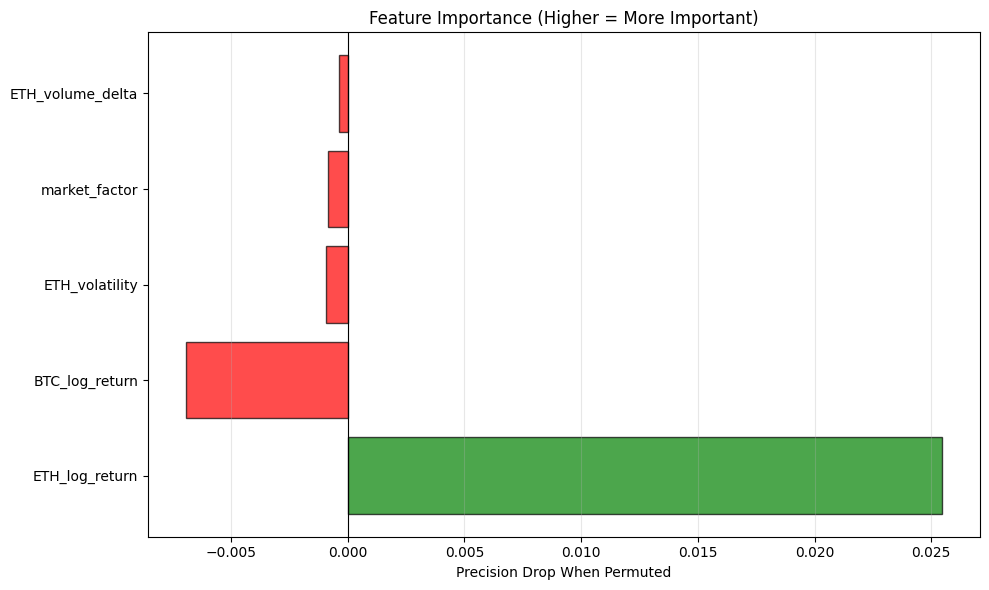


📊 Feature importance saved to: results/feature_importance.png


In [91]:
# Analyze feature importance via permutation
print("\n🔍 Feature Importance Analysis (Permutation Method):\n")

baseline_precision = precision_score(y_test, y_pred)
feature_importance = {}

for i, feature_name in enumerate(FEATURES):
    # Permute feature
    X_test_permuted = X_test.copy()
    X_test_permuted[:, :, i] = np.random.permutation(X_test_permuted[:, :, i])
    
    # Get predictions with permuted feature
    y_pred_permuted = (model.predict(X_test_permuted, verbose=0) > 0.5).astype(int).flatten()
    permuted_precision = precision_score(y_test, y_pred_permuted)
    
    # Importance = drop in precision when feature is randomized
    importance = baseline_precision - permuted_precision
    feature_importance[feature_name] = importance
    
    print(f"{feature_name:30s}: {importance:+.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
features_sorted = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)
names, importances = zip(*features_sorted)

colors = ['green' if x > 0 else 'red' for x in importances]
plt.barh(names, importances, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Precision Drop When Permuted')
plt.title('Feature Importance (Higher = More Important)')
plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Feature importance saved to: results/feature_importance.png")

## Summary & Key Insights

### "Forced Direction" Strategy Implementation ✅

**Key Design Decision**: Train only on clear directional signals (Buy/Sell), ignoring ambiguous neutral samples.

#### Implementation Details:

1. **3-Class Labeling** (`get_triple_barrier_labels`):
   - Class `1`: Profit Target hit first → **Buy**
   - Class `-1`: Stop Loss hit first → **Sell**
   - Class `0`: Time Limit hit first → **Neutral** (filtered out)

2. **Tensor-Level Filtering** (`create_filtered_dataset`):
   - ✅ Preserves DataFrame integrity (no row deletion)
   - ✅ Filters AFTER windowing: `mask = (y != 0)`
   - ✅ Remaps labels: `-1 → 0` (Sell), `1 → 1` (Buy)
   - ✅ Maintains LSTM lookback continuity

3. **Why This Approach Works**:
   - **Sequence Integrity**: Lookback windows reference correct historical data
   - **Signal Quality**: Model learns from decisive price movements only
   - **Noise Reduction**: Eliminates ambiguous "time limit" samples
   - **Binary Classification**: Clean Sell/Buy decision (no neutral class confusion)

### Model Performance
- **Primary Metric (Precision)**: Measures correct Buy signals
- **Target**: >65% precision (better than random)
- **Trade-off**: High precision may sacrifice recall (miss some opportunities)

### Key Design Decisions
1. **Market Factor via PCA**: Aggregates 9 altcoins into 1 feature, capturing market sentiment
2. **Dynamic ATR Barriers**: Adapts to volatility (wider in volatile markets)
3. **Purged Time Split**: 2-hour gap prevents data leakage
4. **High Dropout (0.4)**: Essential for noisy crypto data
5. **Precision Focus**: Prioritizes correct signals over finding all opportunities
6. **Forced Direction**: Trains only on clear Buy/Sell signals

### Next Steps
- [ ] Hyperparameter tuning (LSTM units, dropout rate)
- [ ] Experiment with different PT/SL ratios
- [ ] Analyze performance difference between forced direction vs full 3-class
- [ ] Add more sophisticated features (order flow, funding rates)
- [ ] Ensemble multiple models
- [ ] Backtest with transaction costs

In [92]:
# Save final results summary
summary = {
    'model_config': {
        'target_asset': TARGET_ASSET,
        'lookback': LOOKBACK_L,
        'horizon': HORIZON_H,
        'features': FEATURES,
        'pt_multiplier': PT_MULTIPLIER,
        'sl_multiplier': SL_MULTIPLIER
    },
    'test_metrics': {
        'precision': float(test_precision),
        'recall': float(test_recall),
        'accuracy': float(test_acc),
        'loss': float(test_loss)
    },
    'feature_importance': feature_importance
}

import json
with open('results/model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Model summary saved to: results/model_summary.json")
print("\n🎉 Analysis Complete!")


✅ Model summary saved to: results/model_summary.json

🎉 Analysis Complete!
